### PROJECT GOAL:
 Create a model that can detect the type of retinopathy with the dataset attached below


### Business Case:  
  
Retinopathy refers to damage or disease of the retina, the light-sensitive tissue at the back of the eye responsible for vision. It can lead to vision problems and, in severe cases, blindness. Retinopathy is often associated with systemic conditions like diabetes and high blood pressure, which affect the blood vessels in the retina.


# Domain Analyses:


###Why do we need this study?
The prevalence of diabetic retinopathy is alarmingly high, affecting a significant proportion of individuals with long-standing diabetes. Early detection and timely treatment are crucial for preventing vision loss and improving patient outcomes. However, manual interpretation of retinal images for diabetic retinopathy screening can be time-consuming and subject to human error. Therefore, there is a pressing need for an automated and accurate tool that can assist healthcare professionals in grading the severity of diabetic retinopathy

## Problem Statement:

The existing methods for detecting and grading Diabetic Retinopathy often rely on subjective assessments and extensive manual labor, leading to inefficiencies and potential inconsistencies in diagnosis. Moreover, the increasing prevalence of diabetes and the limited availability of ophthalmologists further exacerbate the challenges in timely screening and diagnosis. Therefore, there is a need to develop a robust and reliable automated system that can accurately detect and grade diabetic retinopathy, enabling early intervention and personalized treatment plans.

##Study Aim:

This project aims to employ Convolutional Neural Networks (CNNs) for diabetic retinopathy detection using different CNN models. By leveraging the power of Deep Learning Algorithms, we aim to develop a model that can analyze retinal images and accurately classify them based on the severity of Diabetic Retinopathy. This study seeks to provide an automated and efficient solution to assist healthcare professionals in diagnosing and grading diabetic retinopathy, ultimately improving patient care and reducing the risk of vision loss.

# 1- Import libraries

In [1]:
# Install imbalanced-learn if needed
!pip install -U imbalanced-learn
# Install packages if needed
!pip install opencv-python
!pip install tensorflow
# ==== Core Libraries ====
import os
import shutil
import pathlib
import time
import random
import itertools
import warnings
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# ==== Image Processing ====
import cv2
from PIL import Image, UnidentifiedImageError

# ==== TensorFlow & Keras ====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    InputLayer, BatchNormalization, Dropout,
    Conv2D, MaxPooling2D, Flatten, Dense,
    Activation, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ==== Pretrained Models ====
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, InceptionResNetV2,
    MobileNetV2, DenseNet121, EfficientNetB3
)

# ==== Keras Utils ====
from keras.utils import to_categorical

# ==== Class Weight Calculation ====
from sklearn.utils.class_weight import compute_class_weight

# ==== Scikit-learn ====
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# ==== imbalanced-learn ====
import imblearn



# ==== Warnings & Logging Cleanup ====
warnings.filterwarnings("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print("All done ✅")


All done ✅


# 2- Import DataSet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> ## Extract Compressed Files

In [3]:
# execute this only once... if you run again, skip this part
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/AI project/AIPRCL-003-Retinopathy/ratinopathy.zip", 'r') as zip_ref:        # get the path for train.zip using copypath. paste the link within the quotation
     # creates new folder and saves all images present in train.zip
    zip_ref.extractall("/content/extracted_images")  # create a new folder, rename it and get the path of it using copypath.. paste the link here



In [4]:
files_list = os.listdir("/content/extracted_images")

# Count the number of files
num_files = len(files_list)
print(num_files)
# Print the names of the files
for file_name in files_list:
    print(file_name)

2
images
data_all.csv


In [5]:
# import data
df = pd.read_csv('/content/extracted_images/data_all.csv')

img_path="/content/extracted_images/images"

# check shape
print(df.shape)


print(df.head())

files_list = os.listdir("/content/extracted_images/images")

# Count the number of files
num_files = len(files_list)
print(num_files)


(1764, 3)
   Unnamed: 0                 file  cat
0           0    o_c1t10003118.jpg    1
1           1  o_c1t1003016260.jpg    1
2           2  o_c1t1004522299.jpg    1
3           3  o_c1t1008823172.jpg    1
4           4  o_c1t1011431188.jpg    1
1764


#3.A- Data Prepocessing

In [6]:
BATCH_SIZE = 16
image_height = 224
image_width = 224

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1764 non-null   int64 
 1   file        1764 non-null   object
 2   cat         1764 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 41.5+ KB


In [8]:
df["cat"].value_counts()

,count
cat,
1,811
2,569
3,384


Text(0.5, 0, 'cat')

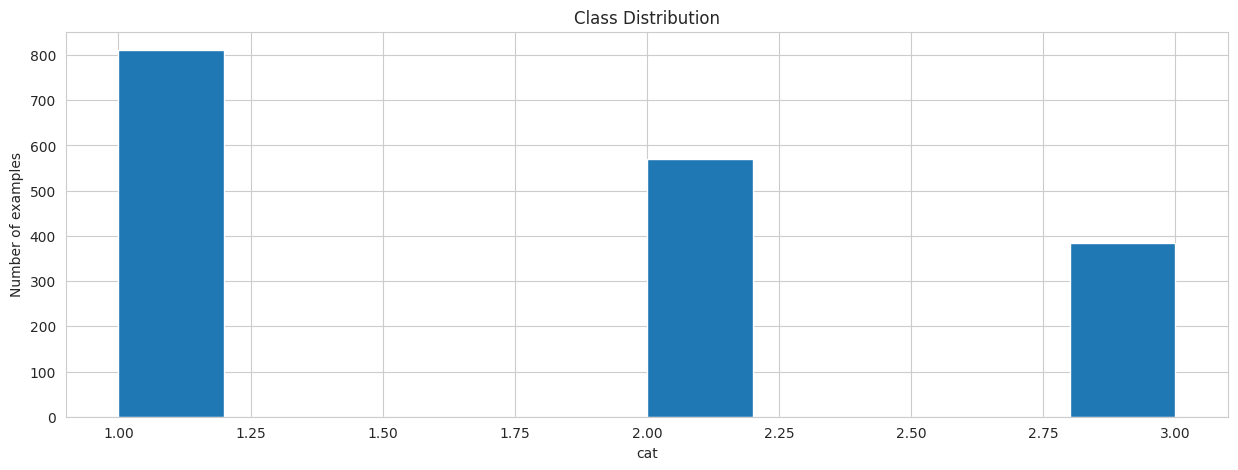

In [9]:
# CLASS DISTRIBUTION

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(df['cat'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('cat')

In [10]:


# Define the image folder path
image_folder = "/content/extracted_images/images"

# Insert image_path as the fourth column
df.insert(3, "Paths", df["file"].apply(lambda x: os.path.join(image_folder, x)))

# Display the updated DataFrame
print(df.head())


   Unnamed: 0                 file  cat  \
0           0    o_c1t10003118.jpg    1   
1           1  o_c1t1003016260.jpg    1   
2           2  o_c1t1004522299.jpg    1   
3           3  o_c1t1008823172.jpg    1   
4           4  o_c1t1011431188.jpg    1   

                                               Paths  
0  /content/extracted_images/images/o_c1t10003118...  
1  /content/extracted_images/images/o_c1t10030162...  
2  /content/extracted_images/images/o_c1t10045222...  
3  /content/extracted_images/images/o_c1t10088231...  
4  /content/extracted_images/images/o_c1t10114311...  


In [11]:
# Rename "cat" column to "Labels"
df = df.rename(columns={"cat": "Labels"})

# Display the updated DataFrame
print(df.head())


   Unnamed: 0                 file  Labels  \
0           0    o_c1t10003118.jpg       1   
1           1  o_c1t1003016260.jpg       1   
2           2  o_c1t1004522299.jpg       1   
3           3  o_c1t1008823172.jpg       1   
4           4  o_c1t1011431188.jpg       1   

                                               Paths  
0  /content/extracted_images/images/o_c1t10003118...  
1  /content/extracted_images/images/o_c1t10030162...  
2  /content/extracted_images/images/o_c1t10045222...  
3  /content/extracted_images/images/o_c1t10088231...  
4  /content/extracted_images/images/o_c1t10114311...  


In [12]:
# Drop the "Unnamed: 0" column
Df = df.drop(columns=["file","Unnamed: 0"], errors="ignore")
print(Df.head())
Df

   Labels                                              Paths
0       1  /content/extracted_images/images/o_c1t10003118...
1       1  /content/extracted_images/images/o_c1t10030162...
2       1  /content/extracted_images/images/o_c1t10045222...
3       1  /content/extracted_images/images/o_c1t10088231...
4       1  /content/extracted_images/images/o_c1t10114311...


,Labels,Paths
0,1,/content/extracted_images/images/o_c1t10003118...
1,1,/content/extracted_images/images/o_c1t10030162...
2,1,/content/extracted_images/images/o_c1t10045222...
3,1,/content/extracted_images/images/o_c1t10088231...
4,1,/content/extracted_images/images/o_c1t10114311...
...,...,...
1759,3,/content/extracted_images/images/o_c3t99292610...
1760,3,/content/extracted_images/images/o_c3t99392912...
1761,3,/content/extracted_images/images/o_c3t99402372...
1762,3,/content/extracted_images/images/o_c3t99671074...


In [13]:
Df['Labels'] = Df['Labels'].astype(str)

In [14]:
Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Labels  1764 non-null   object
 1   Paths   1764 non-null   object
dtypes: object(2)
memory usage: 27.7+ KB


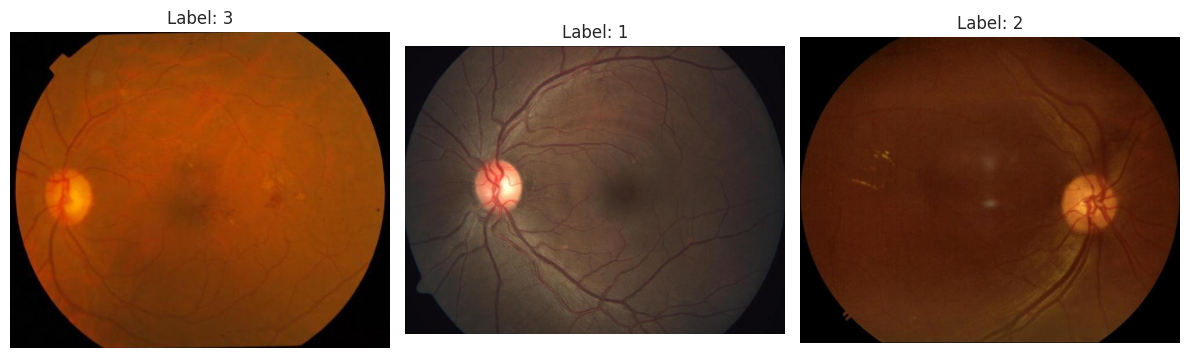

In [15]:

# Group by label and sample one image per label
unique_labels = df['Labels'].unique()
selected_labels = random.sample(list(unique_labels), 3)  # 3 unique labels randomly

# Sample one image for each selected label
sampled_rows = pd.concat([df[df['Labels'] == label].sample(1) for label in selected_labels])

# Display images
plt.figure(figsize=(12, 4))
for i, (idx, row) in enumerate(sampled_rows.iterrows()):
    img = Image.open(row['Paths'])
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Label: {row["Labels"]}')
    plt.axis('off')
plt.tight_layout()
plt.show()



## Label 1 image Visual Features:

Uniform coloration.

No microaneurysms.

No hemorrhages or exudates.

Blood vessels appear clean, regular, and undistorted.

🧠 Interpretation: This retina appears healthy. It lacks the microvascular changes typically associated with diabetic retinopathy.


## Label 2 image Visual Features:

Small red dots near the macula: likely microaneurysms.

Yellowish areas: possibly hard exudates.

No cotton wool spots or large hemorrhages.

🧠 Interpretation: This is early-stage DR. The small microaneurysms and slight leakages suggest early vessel damage but no serious retinal bleeding or ischemia yet.
## Label 3 image Visual Features:

Blotchy red areas: retinal hemorrhages.

Cloudy white patches: cotton wool spots (nerve fiber swelling due to ischemia).

Blood vessels look irregular and possibly dilated or occluded.

🧠 Interpretation: This represents advanced non-proliferative DR. The presence of hemorrhages and ischemic signs shows extensive retinal damage.


### Diabetic Retinopathy (DR):	Normal retina, no signs of vascular damage.

### Mild Diabetic Retinopathy (DR):	Early changes like microaneurysms (small red dots), mild leakages.
### Severe Diabetic Retinopathy (DR):	Large hemorrhages, cotton wool spots, neovascularization, vessel damage

In [16]:
# prompt: replace the labels into none,mild,severe

# Update DataFrame labels
Df['Labels'] = Df['Labels'].replace({'1':'No DR','2':'Mild DR', '3': 'Severe DR'})
Df

,Labels,Paths
0,No DR,/content/extracted_images/images/o_c1t10003118...
1,No DR,/content/extracted_images/images/o_c1t10030162...
2,No DR,/content/extracted_images/images/o_c1t10045222...
3,No DR,/content/extracted_images/images/o_c1t10088231...
4,No DR,/content/extracted_images/images/o_c1t10114311...
...,...,...
1759,Severe DR,/content/extracted_images/images/o_c3t99292610...
1760,Severe DR,/content/extracted_images/images/o_c3t99392912...
1761,Severe DR,/content/extracted_images/images/o_c3t99402372...
1762,Severe DR,/content/extracted_images/images/o_c3t99671074...


## B- Split data into train, valid, test

In [17]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (1411, 2)
Valid shape:  (176, 2)
Test shape:  (177, 2)


,count
Labels,
No DR,657
Mild DR,456
Severe DR,298


## C- Data Augmentation

In [18]:

# Convert 'Labels' column to strings
train['Labels'] = train['Labels'].astype(str)
valid['Labels'] = valid['Labels'].astype(str)
test['Labels'] = test['Labels'].astype(str)

# Now you can create your generators
batch_size = 16   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 1411 validated image filenames belonging to 3 classes.
Found 176 validated image filenames belonging to 3 classes.
Found 177 validated image filenames belonging to 3 classes.


## D- Represent a sample

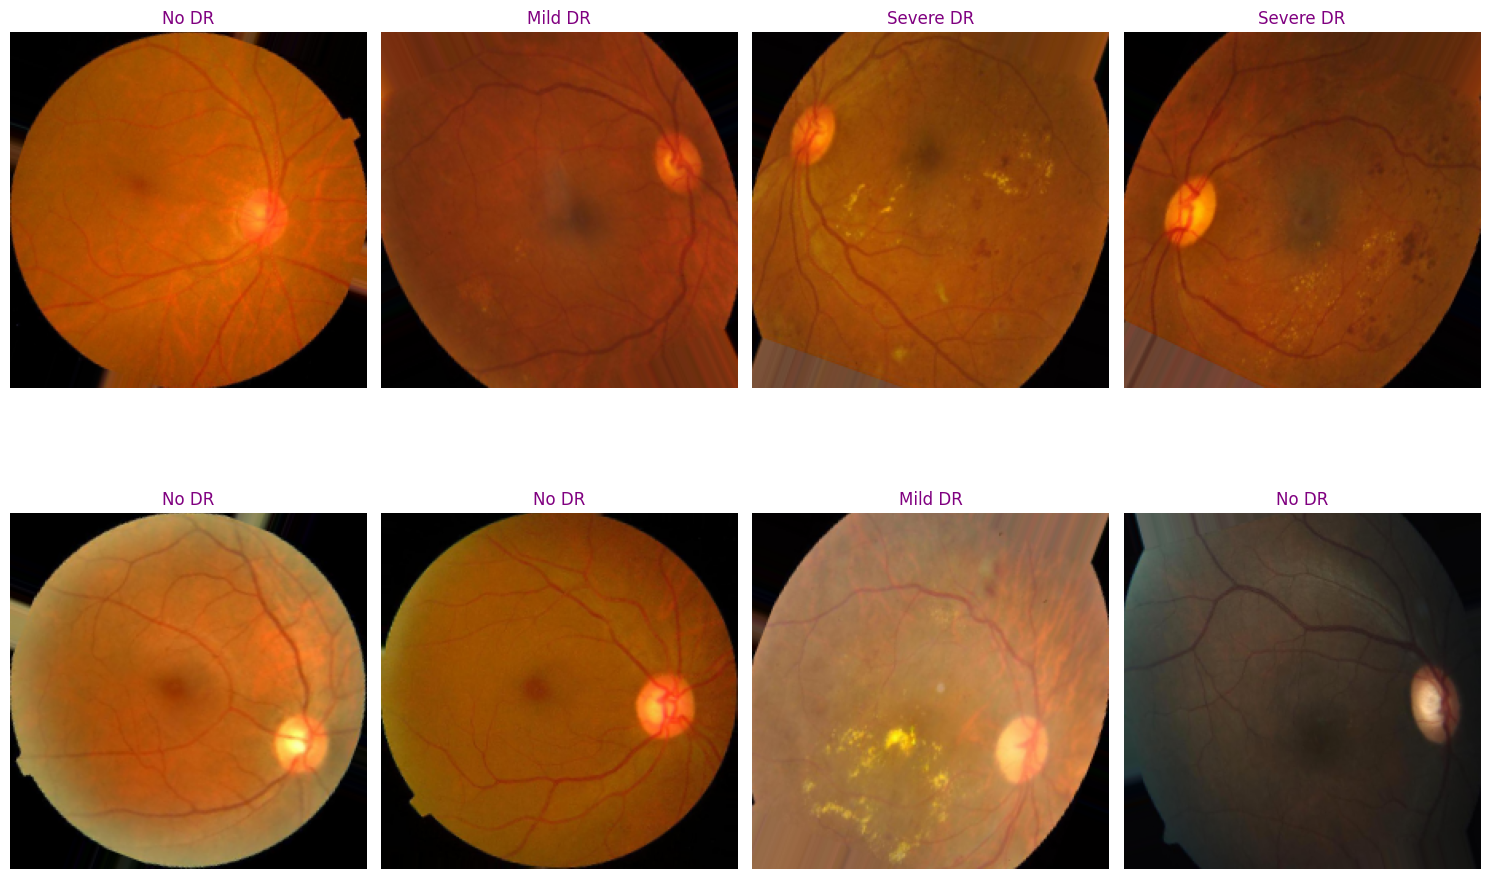

In [19]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    plt.imshow(imgs[i]/255)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# 4- EDA
## 4.1 Distribution of Class Label

In [20]:
dict_class = Train.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'Mild DR': 0, 'No DR': 1, 'Severe DR': 2}
Class labels: ['Mild DR', 'No DR', 'Severe DR']


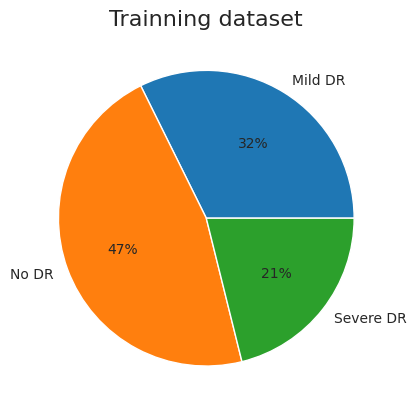

In [21]:
frequency = np.unique(Train.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

## 4.2 Class Weights

In [22]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(Train.classes), y= Train.classes)
class_weights = dict(zip(np.unique(Train.classes), class_weights))
class_weights

{np.int64(0): np.float64(1.0314327485380117),
 np.int64(1): np.float64(0.7158802638254693),
 np.int64(2): np.float64(1.5782997762863535)}

# 5 Modelling

### A- EfficientNetB3

In [23]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005), # Changed l to 0.01 or l2=0.01 if using tf 2.9 or above
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005), # Changed l to 0.01 or l2=0.01 if using tf 2.9 or above
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005), # Changed l to 0.01 or l2=0.01 if using tf 2.9 or above
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(3, activation='softmax'))


In [25]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,735,090 (44.77 MB)

 Trainable params: 11,647,787 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

## B- Visualize model layers

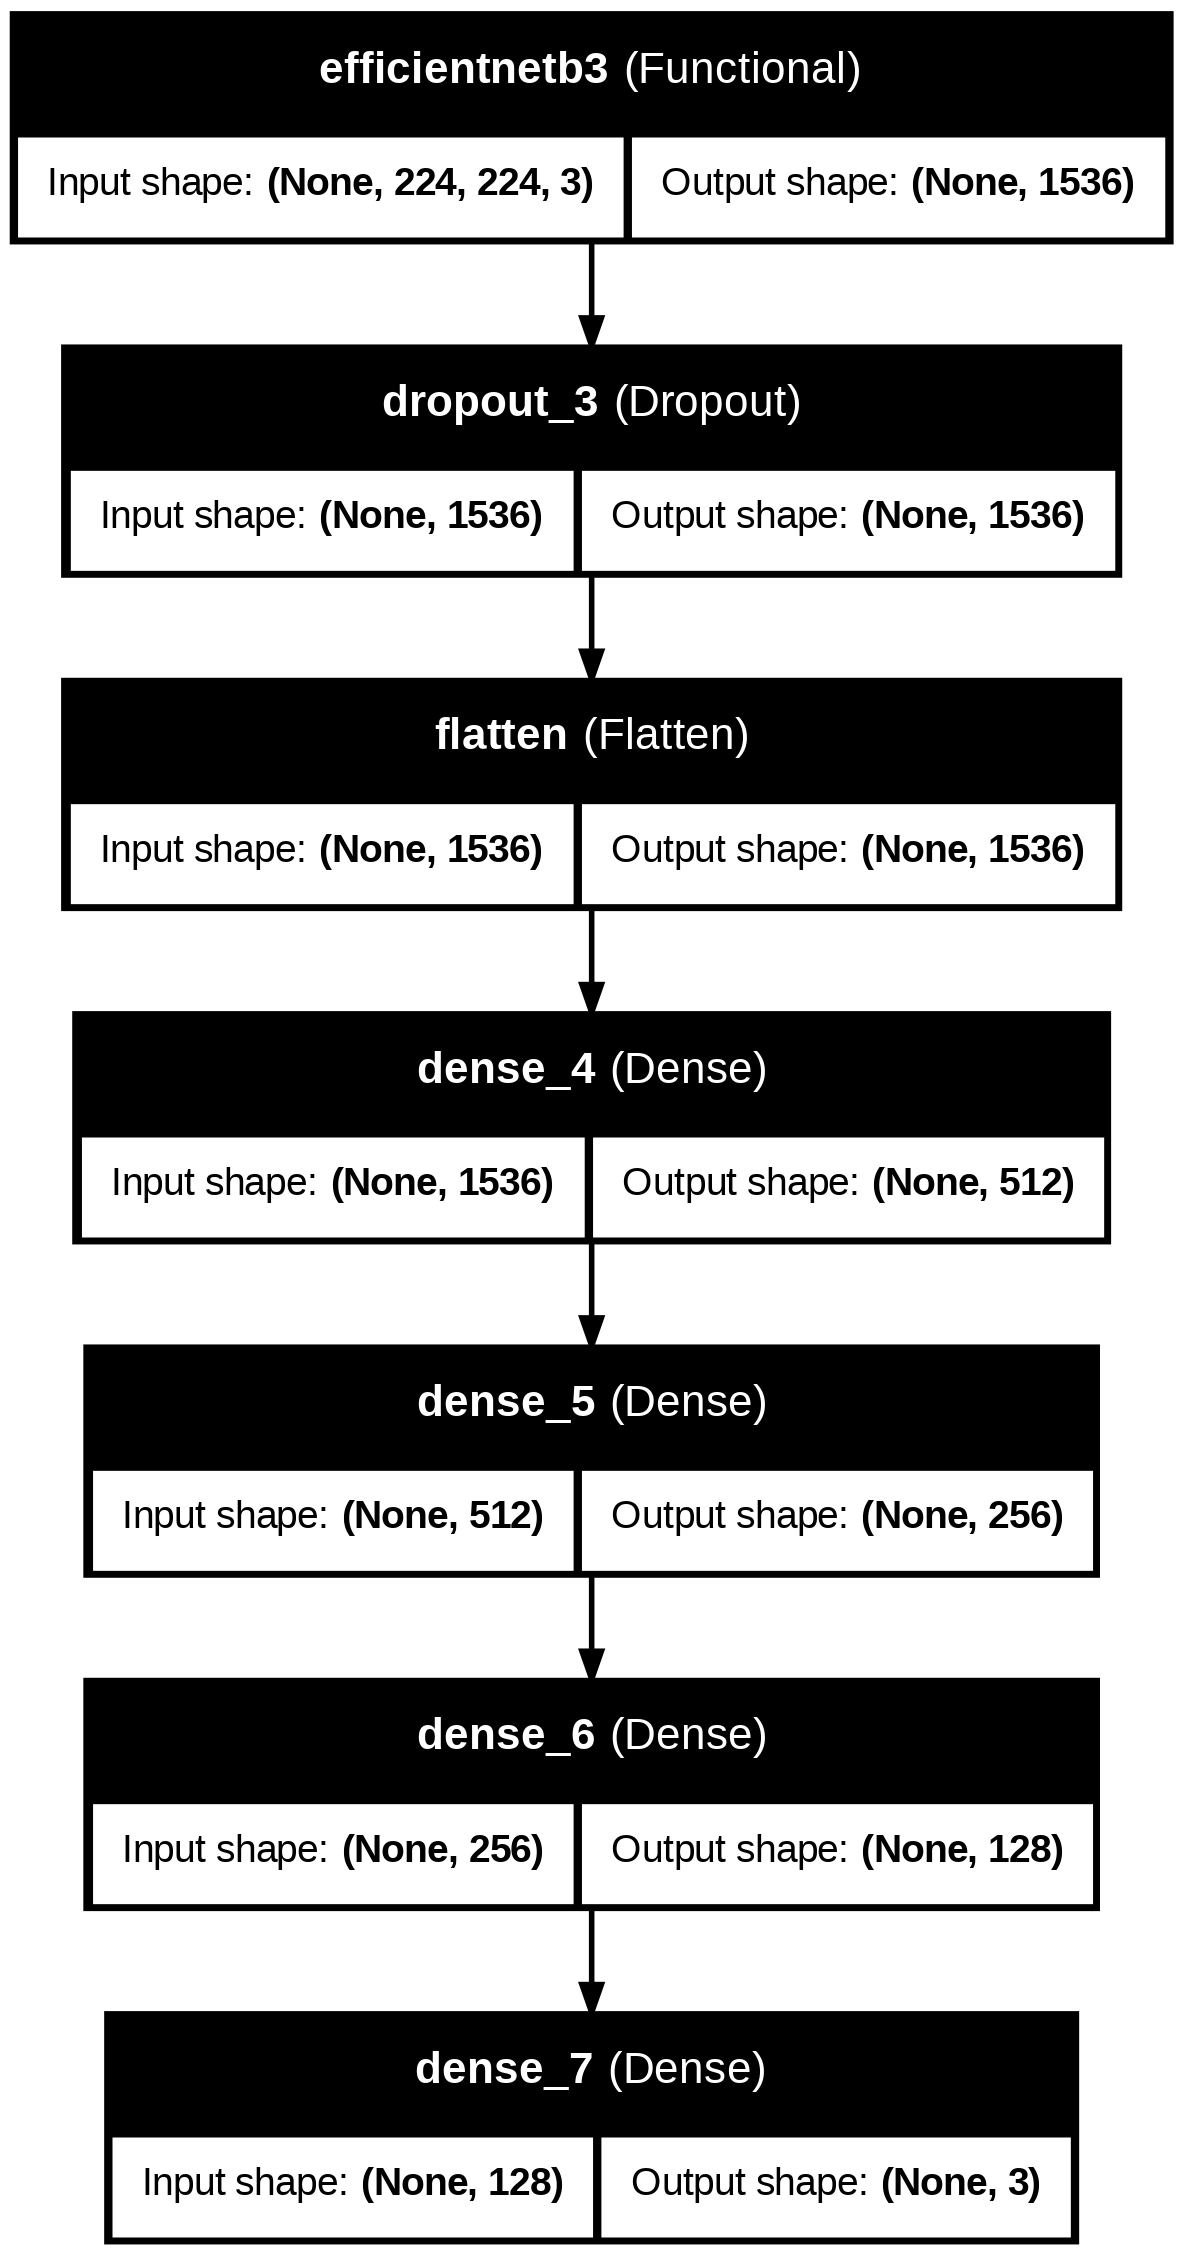

In [27]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

## C- Training phase

In [28]:
epochs = 50
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - acc: 0.5200 - loss: 1.4420 - val_acc: 0.5455 - val_loss: 1.1700
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - acc: 0.6549 - loss: 0.8537 - val_acc: 0.6875 - val_loss: 0.7587
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - acc: 0.6639 - loss: 0.7676 - val_acc: 0.7045 - val_loss: 0.6788
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 286ms/step - acc: 0.7150 - loss: 0.6662 - val_acc: 0.6761 - val_loss: 0.6360
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - acc: 0.7315 - loss: 0.6291 - val_acc: 0.7216 - val_loss: 0.5510
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - acc: 0.7767 - loss: 0.4928 - val_acc: 0.7443 - val_loss: 0.5187
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - acc: 0.7684 - loss: 0.4912 - val_acc: 0.7727 - val_loss: 0.4838
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 295ms/step - acc: 0.7599 - loss: 0.5159 - val_acc: 0.7784 - val_loss: 0.5147
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/st

## D- Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted class: Moderate
Predicted class: Moderate


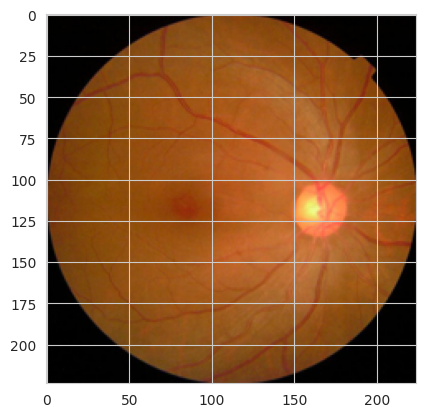

In [29]:


from PIL import Image
prediction_datagen = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30,
    fill_mode='nearest',

)
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images
    img = img / 255.0  # Normalize the image
    return img


# Function to preprocess and predict an image
def preprocess_and_predict(image_path, model):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image using the prediction ImageDataGenerator
    img_preprocessed = next(prediction_datagen.flow(img_array, batch_size=1))

    # Predict
    prediction = model.predict(img_preprocessed)
    predicted_class = np.argmax(prediction, axis=1)

    return predicted_class, img


# Example usage
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

prediction_datagen = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30,
    fill_mode='nearest'
)

def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images
    img = img / 255.0  # Normalize the image
    return img


# Function to preprocess and predict an image
def preprocess_and_predict(image_path, model, img_size):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image using the prediction ImageDataGenerator
    img_preprocessed = next(prediction_datagen.flow(img_array, batch_size=1))

    # Predict
    prediction = model.predict(img_preprocessed)
    predicted_class = np.argmax(prediction, axis=1)

    return predicted_class, img_array


# Example usage
# Assuming img_path, model, and img_size are defined elsewhere
image_path = os.path.join(img_path, 'o_c1t1003016260.jpg') # Replace with your image path
predicted_class, predictions = preprocess_and_predict(image_path, model, img_size)

# Define the class names
class_names = ['No DR', 'Moderate', 'Severe']

import matplotlib.pyplot as plt
# Print the results

print(f"Predicted class: {class_names[predicted_class[0]]}")
plt.imshow(predictions[0].astype(np.uint8)) #added .astype(np.uint8) to fix the error

import matplotlib.pyplot as plt
# Print the results

print(f"Predicted class: {class_names[predicted_class[0]]}")

plt.imshow(predictions[0].astype(np.uint8))

In [30]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

## E- Let's Visualize it

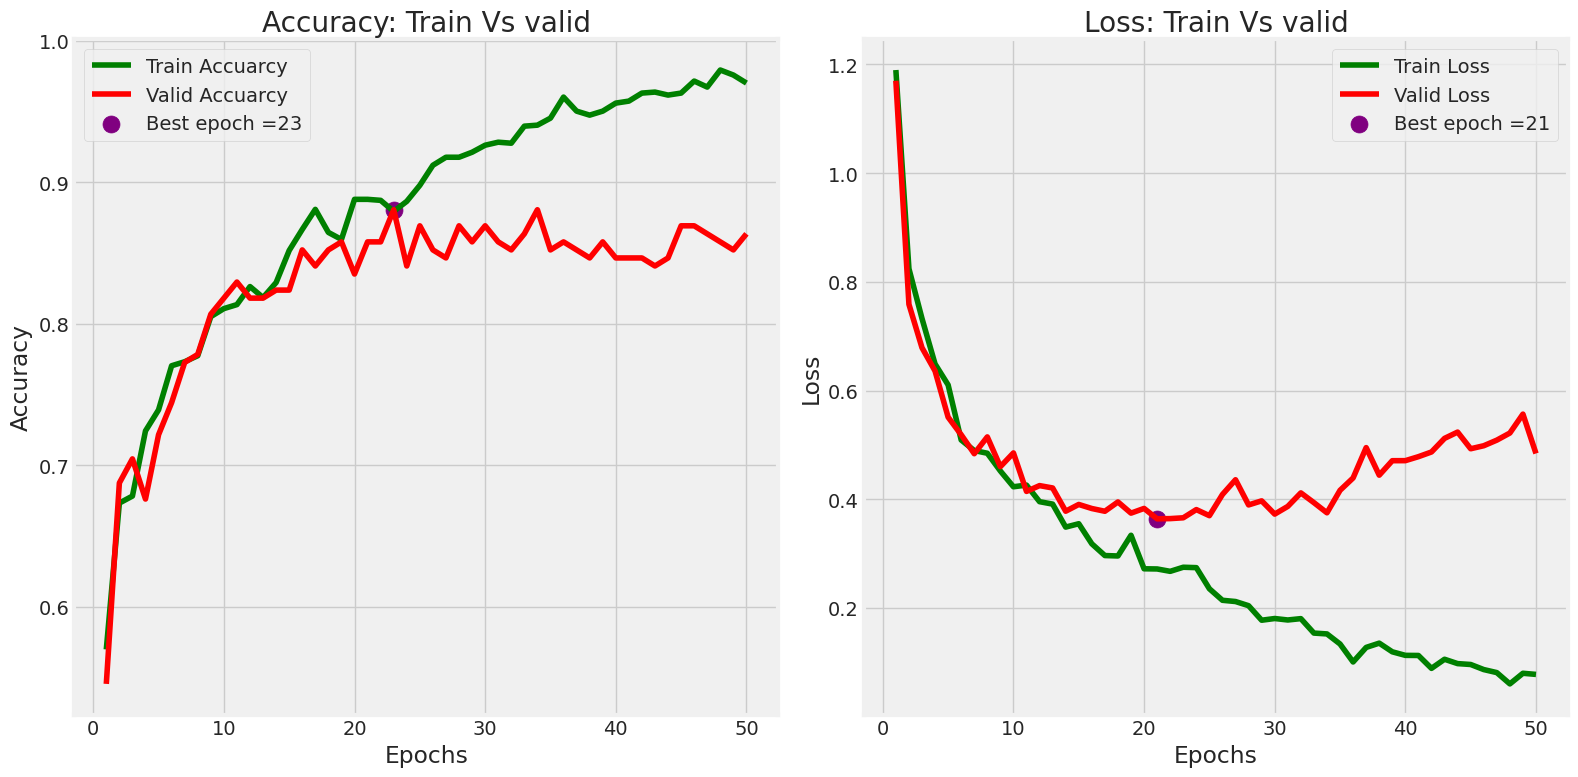

In [31]:

plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 286ms/step - acc: 0.9991 - loss: 0.0079
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - acc: 0.8623 - loss: 0.5076
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 565ms/step - acc: 0.8141 - loss: 0.7249
Train Scores : 
    accuracy: 0.9971651434898376 
      Loss:  0.010093310847878456 
________________________
Valid Scores : 
    accuracy: 0.8636363744735718 
      Loss:  0.4841567277908325 
________________________
Test Scores : 
    accuracy: 0.8192090392112732 
      Loss:  0.7736826539039612 
________________________


## Get predictions

In [33]:
predictions = model.predict(Test) # Use predict instead of predict_generator
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 856ms/step
[[6.54527009e-01 2.21739101e-04 3.45251203e-01]
 [9.92791772e-01 6.79143006e-04 6.52913982e-03]
 [9.98009622e-01 2.01226385e-06 1.98833109e-03]
 [9.94308531e-01 4.25475463e-03 1.43673585e-03]
 [9.59286783e-09 1.00000000e+00 2.45319065e-13]
 [8.70609760e-01 1.67758297e-02 1.12614378e-01]
 [9.78136599e-01 4.96475841e-04 2.13669557e-02]
 [1.39797693e-02 1.34621278e-05 9.86006737e-01]
 [6.79591596e-01 1.00875618e-02 3.10320854e-01]
 [2.42994856e-02 1.01427268e-02 9.65557814e-01]
 [4.69214910e-06 9.99995351e-01 7.16930237e-10]
 [1.88493177e-05 9.99981165e-01 3.83264620e-08]
 [6.29095793e-01 2.84234714e-03 3.68061870e-01]
 [8.70150174e-08 9.99999881e-01 1.33698900e-12]
 [2.42803955e-09 1.00000000e+00 3.61012185e-14]
 [7.34261703e-04 4.91824248e-05 9.99216557e-01]
 [1.26350074e-04 9.99869943e-01 3.70668931e-06]
 [7.74577856e-01 4.74892072e-02 1.77932873e-01]
 [7.16125360e-03 5.44701761e-04 9.92294073e-01]
 [9.98870552e-01 1.93274755e-05 1.11011229e-03

In [34]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[41,  7, 14],
       [ 0, 71,  0],
       [10,  1, 33]])

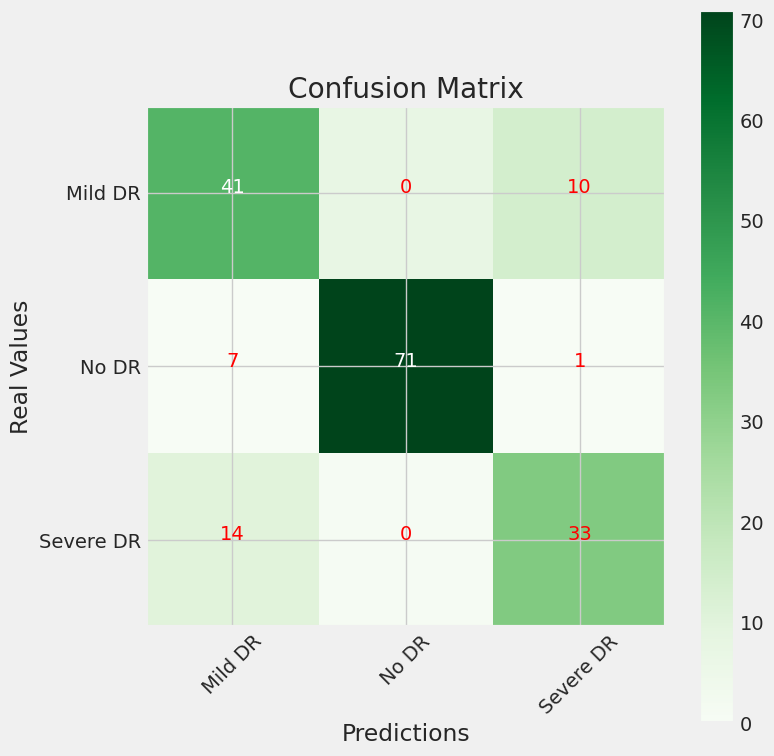

In [35]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [36]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

     Mild DR       0.80      0.66      0.73        62
       No DR       0.90      1.00      0.95        71
   Severe DR       0.70      0.75      0.73        44

    accuracy                           0.82       177
   macro avg       0.80      0.80      0.80       177
weighted avg       0.82      0.82      0.81       177



# Using Different Convolutional neural networks (CNNs)

In [37]:
# Define the epochs for training
EPOCHS = 50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Increased patience for early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Let it wait longer
    verbose=1,
    restore_best_weights=True
)

# Reduce LR more gradually
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,        # Less aggressive than 0.001
    patience=5,        # Wait 5 epochs before reducing
    min_lr=1e-6,       # Don’t let it go too low
    verbose=1
)

# (Optional) Save best model during training
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert Labels to strings (you already did this — good!)
train['Labels'] = train['Labels'].astype(str)
valid['Labels'] = valid['Labels'].astype(str)
test['Labels'] = test['Labels'].astype(str)

# Configuration
batch_size = 16
img_size = (224, 224)  # Use 224x224 for pretrained models
channels = 3
img_shape = (*img_size, channels)

# Improved Training Generator
tr_G = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.05,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)


# Validation and Test Generators (Only rescale)
V_G = ImageDataGenerator(rescale=1./255)
t_G = ImageDataGenerator(rescale=1./255)

# DataFrame-based Generators
Train = tr_G.flow_from_dataframe(
    dataframe=train,
    x_col='Paths',
    y_col='Labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Valid = V_G.flow_from_dataframe(
    dataframe=valid,
    x_col='Paths',
    y_col='Labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Test = t_G.flow_from_dataframe(
    dataframe=test,
    x_col='Paths',
    y_col='Labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)


train_data = Train

Found 1411 validated image filenames belonging to 3 classes.
Found 176 validated image filenames belonging to 3 classes.
Found 177 validated image filenames belonging to 3 classes.


## 5.2 VGG16

In [39]:
# Load the pre-trained VGG16 model without the top classification layer
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_VGG16.layers:
    layer.trainable = False

# Create a new model and add the VGG16 base model
model_VGG16 = Sequential()
model_VGG16.add(base_model_VGG16)

# Add a fully connected layer and output layer for classification
model_VGG16.add(GlobalAveragePooling2D())
model_VGG16.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG16.add(Dropout(0.4))
model_VGG16.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_VGG16.add(Dropout(0.2))
model_VGG16.add(Dense(3, activation='softmax'))

# Model summary
print("Model Summary (VGG16):")
model_VGG16.summary()
print()

# Compile the model
model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=Test, callbacks=[early_stopping], class_weight=class_weights)
# Validate the model
val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(Test, steps=len(Test))
print(f'Validation Loss: {val_loss_VGG16:.4f}')
print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary (VGG16):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,788,803 (56.41 MB)

 Trainable params: 74,115 (289.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 374ms/step - accuracy: 0.4553 - loss: 1.3016 - val_accuracy: 0.5819 - val_loss: 0.8479
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - accuracy: 0.6224 - loss: 0.8655 - val_accuracy: 0.5650 - val_loss: 0.8169
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.6549 - loss: 0.8390 - val_accuracy: 0.6836 - val_loss: 0.7236
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.6644 - loss: 0.8101 - val_accuracy: 0.5932 - val_loss: 0.7269
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step - accuracy: 0.6704 - loss: 0.7540 - val_accuracy: 0.6045 - val_loss: 0.6885
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.6606 - loss: 0.7791 - val_accuracy: 0.6271 - val_loss: 0.6800
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 288ms/step - accuracy: 0.6524 - loss: 0.7463 - val_accuracy: 0.7006 - val_loss: 0.6627
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - accuracy: 0.6816 - loss: 0.7751 - val_acc

In [40]:
# Unfreeze the top layers of VGG16 for fine-tuning
fine_tune_at_vgg = 15  # Unfreeze last few layers of VGG16

for layer in base_model_VGG16.layers[:fine_tune_at_vgg]:
    layer.trainable = False
for layer in base_model_VGG16.layers[fine_tune_at_vgg:]:
    layer.trainable = True

# Recompile with a lower learning rate
model_VGG16.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Fine-tune the model
fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs
# Fine-tune the model
print("🔁 Fine-tuning VGG16...")
history_fine_tune_vgg = model_VGG16.fit(
    train_data,
    epochs=total_epochs,
    initial_epoch=EPOCHS,
    validation_data=Test,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# Evaluate fine-tuned VGG16
val_loss_ft_vgg, val_acc_ft_vgg = model_VGG16.evaluate(Test, steps=len(Test))
print(f'🔍 Fine-Tuned VGG16 Validation Accuracy: {val_acc_ft_vgg:.4f}')
print(f'Fine-Tuned Validation Loss: {val_loss_ft_vgg:.4f}')


🔁 Fine-tuning VGG16...
Epoch 51/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 37s 358ms/step - accuracy: 0.7242 - loss: 0.7073 - val_accuracy: 0.7401 - val_loss: 0.6055 - learning_rate: 1.0000e-05
Epoch 52/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 304ms/step - accuracy: 0.7114 - loss: 0.6787 - val_accuracy: 0.7288 - val_loss: 0.6153 - learning_rate: 1.0000e-05
Epoch 53/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 28s 309ms/step - accuracy: 0.7434 - loss: 0.6294 - val_accuracy: 0.7401 - val_loss: 0.5759 - learning_rate: 1.0000e-05
Epoch 54/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - accuracy: 0.7315 - loss: 0.6353 - val_accuracy: 0.7458 - val_loss: 0.5991 - learning_rate: 1.0000e-05
Epoch 55/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 307ms/step - accuracy: 0.7456 - loss: 0.6273 - val_accuracy: 0.7401 - val_loss: 0.5608 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 55.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7621 - loss: 0.5414 
🔍 Fine-Tuned VGG16 Validation Accuracy: 0.7401
Fine-

## 5.3 MobileNetV2

In [41]:

# Load the pre-trained MobileNetV2 model without the top classification layer
base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_MobileNet.layers:
    layer.trainable = False

# Create a new model and add the MobileNetV2 base model
model_MobileNet = Sequential()
model_MobileNet.add(base_model_MobileNet)

# Add a global average pooling layer and output layer for classification
model_MobileNet.add(GlobalAveragePooling2D())
model_MobileNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNet.add(Dropout(0.4))
model_MobileNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNet.add(Dropout(0.2))
model_MobileNet.add(Dense(3, activation='softmax'))

# Model summary
print("Model Summary (MobileNetV2):")
model_MobileNet.summary()
print()

# Compile the model
model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=Test, callbacks=[early_stopping], class_weight=class_weights)

# Validate the model
val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(Test, steps=len(Test))
print(f'Validation Loss: {val_loss_MobileNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary (MobileNetV2):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,403 (9.27 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 377ms/step - accuracy: 0.5429 - loss: 1.2825 - val_accuracy: 0.7514 - val_loss: 0.8175
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 248ms/step - accuracy: 0.6828 - loss: 0.9451 - val_accuracy: 0.6723 - val_loss: 0.8048
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - accuracy: 0.7060 - loss: 0.8901 - val_accuracy: 0.7966 - val_loss: 0.6824
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 263ms/step - accuracy: 0.7383 - loss: 0.7774 - val_accuracy: 0.7514 - val_loss: 0.6948
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - accuracy: 0.7503 - loss: 0.7598 - val_accuracy: 0.7797 - val_loss: 0.6491
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 253ms/step - accuracy: 0.7576 - loss: 0.7194 - val_accuracy: 0.7684 - val_loss: 0.6572
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.7559 - loss: 0.7081 - val_accuracy: 0.7684 - val_loss: 0.6570
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - accuracy: 0.7711 - loss: 0.6826 - val_acc

In [42]:
# Unfreeze the last 30 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with a lower learning rate
model_MobileNet.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune training
fine_tune_history = model_MobileNet.fit(train_data, validation_data=Test, epochs=5, callbacks=[early_stopping], class_weight=class_weights)


Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 39s 339ms/step - accuracy: 0.8246 - loss: 0.5346 - val_accuracy: 0.7966 - val_loss: 0.5298
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.8078 - loss: 0.5223 - val_accuracy: 0.7966 - val_loss: 0.5298
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - accuracy: 0.8031 - loss: 0.5512 - val_accuracy: 0.7853 - val_loss: 0.5282
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - accuracy: 0.8146 - loss: 0.5400 - val_accuracy: 0.7853 - val_loss: 0.5271
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 0.8172 - loss: 0.5481 - val_accuracy: 0.7740 - val_loss: 0.5260
Restoring model weights from the end of the best epoch: 5.


In [43]:
from tensorflow.keras.optimizers import Adam

# Step 1: Unfreeze the top layers of MobileNetV2 for fine-tuning
fine_tune_at = 100  # Unfreeze from this layer onward — adjust if needed

for layer in base_model_MobileNet.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model_MobileNet.layers[fine_tune_at:]:
    layer.trainable = True

# Step 2: Recompile the model with a lower learning rate
model_MobileNet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 3: Fine-tune the model
fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

print("🔁 Fine-tuning MobileNetV2...")
history_fine_tune_mobilenet = model_MobileNet.fit(
    train_data,
    epochs=total_epochs,
    initial_epoch=EPOCHS,
    validation_data=Test,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# Step 4: Evaluate the fine-tuned model
val_loss_ft_mobilenet, val_acc_ft_mobilenet = model_MobileNet.evaluate(Test, steps=len(Test))
print(f'🔍 Fine-Tuned MobileNetV2 Validation Accuracy: {val_acc_ft_mobilenet:.4f}')
print(f'Fine-Tuned Validation Loss: {val_loss_ft_mobilenet:.4f}')


🔁 Fine-tuning MobileNetV2...
Epoch 51/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 423ms/step - accuracy: 0.5529 - loss: 0.9930 - val_accuracy: 0.7288 - val_loss: 0.7943 - learning_rate: 1.0000e-05
Epoch 52/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 22s 250ms/step - accuracy: 0.6811 - loss: 0.7551 - val_accuracy: 0.6723 - val_loss: 1.1587 - learning_rate: 1.0000e-05
Epoch 53/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 0.7062 - loss: 0.7471 - val_accuracy: 0.6102 - val_loss: 1.4308 - learning_rate: 1.0000e-05
Epoch 54/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.7088 - loss: 0.7285 - val_accuracy: 0.6271 - val_loss: 1.3684 - learning_rate: 1.0000e-05
Epoch 55/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - accuracy: 0.7570 - loss: 0.6308 - val_accuracy: 0.6271 - val_loss: 1.4256 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 51.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7255 - loss: 0.8389
🔍 Fine-Tuned MobileNetV2 Validation Accuracy: 0

## 5.4 DenseNet

In [44]:

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


N_CLASSES = 3  # Number of output classes
IMG_SHAPE = (image_height, image_width, 3)


# Load DenseNet121 without top layers
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
model_DenseNet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(N_CLASSES, activation='softmax')
])

# Model Summary
print("Model Summary (DenseNet121):")
model_DenseNet.summary()
print()

# Compile
model_DenseNet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history = model_DenseNet.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=Test,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# Evaluate
val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(Test, steps=len(Test))
print(f'Validation Loss: {val_loss_DenseNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Summary (DenseNet121):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,177,155 (27.38 MB)

 Trainable params: 139,651 (545.51 KB)

 Non-trainable params: 7,037,504 (26.85 MB)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 620ms/step - accuracy: 0.3936 - loss: 1.5616 - val_accuracy: 0.6215 - val_loss: 1.1736 - learning_rate: 1.0000e-04
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 276ms/step - accuracy: 0.5500 - loss: 1.1993 - val_accuracy: 0.7062 - val_loss: 0.9892 - learning_rate: 1.0000e-04
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - accuracy: 0.6393 - loss: 1.0659 - val_accuracy: 0.6893 - val_loss: 0.9341 - learning_rate: 1.0000e-04
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 0.6705 - loss: 1.0001 - val_accuracy: 0.6893 - val_loss: 0.9101 - learning_rate: 1.0000e-04
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.7087 - loss: 0.9112 - val_accuracy: 0.7232 - val_loss: 0.8670 - learning_rate: 1.0000e-04
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - accuracy: 0.7242 - loss: 0.8615 - val_accuracy: 0.7288 - val_loss: 0.8196 - learning_rate: 1.0000e-04
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 276ms/step - ac

In [45]:
# Unfreeze the top layers of DenseNet121 for fine-tuning
fine_tune_at = 300  # Unfreeze from this layer onwards (tune based on experimentation)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile with a lower learning rate
model_DenseNet.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs

print("🔁 Fine-tuning DenseNet121...")
history_fine_tune_densenet = model_DenseNet.fit(
    train_data,
    epochs=total_epochs,
    initial_epoch=EPOCHS,
    validation_data=Test,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# Evaluate fine-tuned model
val_loss_ft_densenet, val_acc_ft_densenet = model_DenseNet.evaluate(Test, steps=len(Test))
print(f'🔍 Fine-Tuned DenseNet121 Validation Accuracy: {val_acc_ft_densenet:.4f}')
print(f'Fine-Tuned Validation Loss: {val_loss_ft_densenet:.4f}')


🔁 Fine-tuning DenseNet121...
Epoch 51/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 132s 821ms/step - accuracy: 0.4973 - loss: 1.2294 - val_accuracy: 0.7627 - val_loss: 0.6093 - learning_rate: 1.0000e-05
Epoch 52/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 282ms/step - accuracy: 0.7441 - loss: 0.7289 - val_accuracy: 0.7797 - val_loss: 0.5878 - learning_rate: 1.0000e-05
Epoch 53/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - accuracy: 0.7770 - loss: 0.6898 - val_accuracy: 0.7853 - val_loss: 0.5817 - learning_rate: 1.0000e-05
Epoch 54/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.7910 - loss: 0.6510 - val_accuracy: 0.7797 - val_loss: 0.5850 - learning_rate: 1.0000e-05
Epoch 55/55
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 292ms/step - accuracy: 0.8100 - loss: 0.6044 - val_accuracy: 0.8023 - val_loss: 0.5669 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 55.
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7832 - loss: 0.5698
🔍 Fine-Tuned DenseNet121 Validation Accuracy: 

## 5.5 InceptionV3

In [46]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# Constants
EPOCHS = 20  # Can increase since EarlyStopping prevents overfitting
IMG_SHAPE = (image_height, image_width, 3)
N_CLASSES = len(Train.class_indices)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Load pretrained InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

# Freeze base layers initially
base_model.trainable = False

# Build model
model_InceptionV3= Sequential()
model_InceptionV3.add(base_model)
model_InceptionV3.add(GlobalAveragePooling2D())
model_InceptionV3.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_InceptionV3.add(Dropout(0.4))
model_InceptionV3.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_InceptionV3.add(Dropout(0.2))
model_InceptionV3.add(Dense(N_CLASSES, activation='softmax'))

# Compile
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model_InceptionV3.summary()

# Train
history = model_InceptionV3.fit(
    Train,
    validation_data=Test,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

# Evaluation
val_loss_InceptionV3, val_accuracy_InceptionV3 = model_InceptionV3.evaluate(Test, steps=len(Test))
print(f'Validation Loss: {val_loss_InceptionV3:.4f}')
print(f'Validation Accuracy: {val_accuracy_InceptionV3:.4f}')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,073,507 (84.20 MB)

 Trainable params: 270,723 (1.03 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 483ms/step - accuracy: 0.4481 - loss: 1.4400 - val_accuracy: 0.6271 - val_loss: 1.1491 - learning_rate: 1.0000e-04
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 55s 273ms/step - accuracy: 0.6149 - loss: 1.2027 - val_accuracy: 0.6158 - val_loss: 1.0627 - learning_rate: 1.0000e-04
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.6476 - loss: 1.0985 - val_accuracy: 0.6554 - val_loss: 0.9987 - learning_rate: 1.0000e-04
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 0.6766 - loss: 1.0433 - val_accuracy: 0.6441 - val_loss: 1.0187 - learning_rate: 1.0000e-04
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - accuracy: 0.7072 - loss: 1.0229 - val_accuracy: 0.6893 - val_loss: 0.9594 - learning_rate: 1.0000e-04
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - accuracy: 0.6982 - loss: 1.0052 - val_accuracy: 0.6836 - val_loss: 0.9276 - learning_rate: 1.0000e-04
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - acc

In [47]:
# Unfreeze the base_model
no_base_layers = len(model_InceptionV3.layers)
print('No. of base layers in the model = {}\n'.format(no_base_layers))

# no of layers for fine-tune
no_finetune_layers = int(no_base_layers/2)
print('No. of layers for fine-tune = {}'.format(no_finetune_layers))

No. of base layers in the model = 7

No. of layers for fine-tune = 3


In [48]:
# Fine-tune the model
model_InceptionV3.trainable = True
for layer in model_InceptionV3.layers[: -no_finetune_layers]:
    layer.trainable = False

# small learning rate for fine tuning
model_InceptionV3.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune_Inception = model_InceptionV3.fit(train_data, epochs=EPOCHS, validation_data=Test, callbacks=[early_stopping])


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 53s 443ms/step - accuracy: 0.7024 - loss: 0.6766 - val_accuracy: 0.7571 - val_loss: 0.6661
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 0.7045 - loss: 0.6859 - val_accuracy: 0.7458 - val_loss: 0.6669
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - accuracy: 0.7276 - loss: 0.7066 - val_accuracy: 0.7458 - val_loss: 0.6679
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 272ms/step - accuracy: 0.7047 - loss: 0.6671 - val_accuracy: 0.7401 - val_loss: 0.6690
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 262ms/step - accuracy: 0.7723 - loss: 0.6201 - val_accuracy: 0.7345 - val_loss: 0.6706
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 270ms/step - accuracy: 0.7198 - loss: 0.6846 - val_accuracy: 0.7401 - val_loss: 0.6718
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [49]:
# Validate the model
print('====== Model Validation ======')
val_loss_ft_Inception, val_accuracy_ft_Inception = model_InceptionV3.evaluate(Test, steps=len(Test))
print(f'Validation Loss: {val_loss_ft_Inception:.4f}')
print(f'Validation Accuracy: {val_accuracy_ft_Inception:.4f}')

====== Model Validation ======
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7672 - loss: 0.6631
Validation Loss: 0.6661
Validation Accuracy: 0.7571


In [50]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
# val_generator.reset()
Inception_test_preds = model_InceptionV3.predict(Test)
Inception_test_pred_classes = np.argmax(Inception_test_preds, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 636ms/step


## 6- Comparing model performance

In [51]:

data = {
    'VGG16': val_accuracy_VGG16,
    'Fine tuned VGG16':val_acc_ft_vgg,
    'MobileNet': val_accuracy_MobileNet,
    'Fine tuned MobileNet':val_acc_ft_mobilenet,
    'DenseNet': val_accuracy_DenseNet,
    'Fine tuned DenseNet':val_acc_ft_densenet,
    'InceptionV3':val_accuracy_InceptionV3,
    'Fine tuned InceptionV3 ':val_accuracy_ft_Inception
}


In [52]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

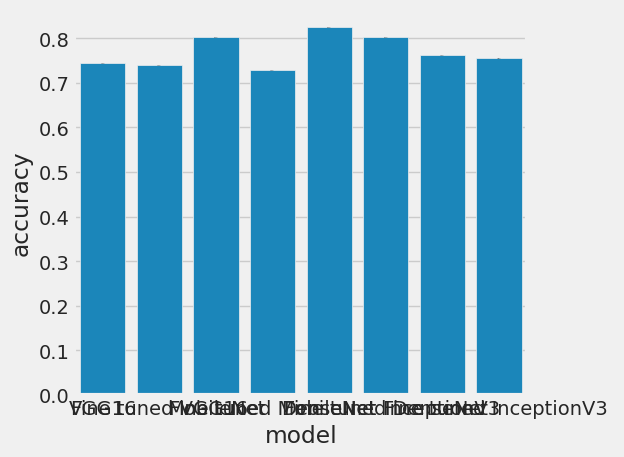

In [53]:
# Create bar chart
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=1)

# Adjust the layout
plt.tight_layout()

plt.show()

## 7. Prediction Result Samples

7.1 Prediction using InceptionV3

In [54]:
Test.reset()
img, label = next(Test)

prediction = model_InceptionV3.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[20, 24])
for i in range(16):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

7.2 prediction using VGG16

In [55]:
Test.reset()
img, label = next(Test)

prediction = model_VGG16.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[20, 24])
for i in range(16):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

7.3 prediction using MobileNet

In [56]:
class_names = ['No DR', 'Moderate', 'Severe', ]
Test.reset()
img, label = next(Test)

prediction = model_MobileNet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[20, 24])
for i in range(16):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

7.4 prediction using DenseNet

In [61]:
class_names = ['No DR', 'Moderate', 'Severe', ]
Test.reset()
img, label = next(Test)

prediction = model_DenseNet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[20, 24])
for i in range(16):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

7.5 prediction using EfficientNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted class: Moderate


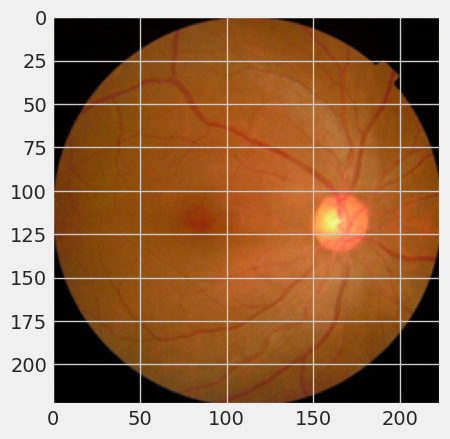

In [58]:

from PIL import Image
prediction_datagen = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30,
    fill_mode='nearest',

)
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images
    img = img / 255.0  # Normalize the image
    return img


# Function to preprocess and predict an image
def preprocess_and_predict(image_path, model):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image using the prediction ImageDataGenerator
    img_preprocessed = next(prediction_datagen.flow(img_array, batch_size=1))

    # Predict
    prediction = model.predict(img_preprocessed)
    predicted_class = np.argmax(prediction, axis=1)

    return predicted_class, img

single_image_path = os.path.join(img_path, 'o_c1t1003016260.jpg')
predicted_class, predictions =preprocess_and_predict(single_image_path,model)




import matplotlib.pyplot as plt
# Print the results

print(f"Predicted class: {class_names[predicted_class[0]]}")
plt.imshow(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted class: Moderate


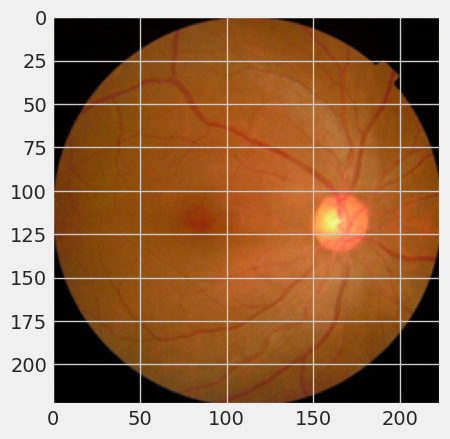

In [59]:

from PIL import Image
prediction_datagen = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30,
    fill_mode='nearest',

)
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images
    img = img / 255.0  # Normalize the image
    return img


# Function to preprocess and predict an image
def preprocess_and_predict(image_path, model):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Preprocess the image using the prediction ImageDataGenerator
    img_preprocessed = next(prediction_datagen.flow(img_array, batch_size=1))

    # Predict
    prediction = model.predict(img_preprocessed)
    predicted_class = np.argmax(prediction, axis=1)

    return predicted_class, img

single_image_path = os.path.join(img_path, 'o_c1t1003016260.jpg')
predicted_class, predictions =preprocess_and_predict(single_image_path,model)




import matplotlib.pyplot as plt
# Print the results

print(f"Predicted class: {class_names[predicted_class[0]]}")
plt.imshow(predictions)


### Conclusion

In this diabetic retinopathy classification project, various deep learning models—including EfficientNet, VGG16,DenseNet,  ResNet50, and MobileNetV2—were trained to classify retinal fundus images into three clinically significant categories: No DR, Mild DR, and Severe DR.

Among all models tested, EfficientNet delivered the highest performance:

Training Accuracy: 99.7%

Validation Accuracy: 86.4%

Test Accuracy: 81.9%